In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from datasets import MyDataset
import numpy as np

## Batch Sizes
train_batch_size = 256
val_batch_size = train_batch_size

## Train-Val Split
train_kwargs = {
    'root':'data/',
    'train':True,
    'download':True,
    'transform':transforms.Compose([transforms.ToTensor()]),
}
val_kwargs = {
    'root':'data/',
    'train':False,
    'download':True,
    'transform':transforms.Compose([transforms.ToTensor()]),
}
dataset_name = 'CIFAR10'
dataset_class = getattr(datasets, dataset_name)
train_dataset_mnist = MyDataset(dataset_class(**train_kwargs).data, dataset_class(**train_kwargs).targets, uses_da=True)
val_dataset_mnist = MyDataset(dataset_class(**val_kwargs).data, dataset_class(**val_kwargs).targets)
val_dataset_mnist.set_norm_values(*train_dataset_mnist.get_norm_values())

## DataLoaders
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=train_batch_size, shuffle=True)
val_loader_mnist = torch.utils.data.DataLoader(val_dataset_mnist, batch_size=val_batch_size)

Files already downloaded and verified
Files already downloaded and verified
x: torch.Size([50000, 3, 32, 32]) - x.max: 1.0 - y: torch.Size([50000]) - y.max: 9
Files already downloaded and verified
Files already downloaded and verified
x: torch.Size([10000, 3, 32, 32]) - x.max: 1.0 - y: torch.Size([10000]) - y.max: 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data torch.Size([256, 3, 32, 32]) cpu torch.float32 tensor(-2.1676) tensor(2.2995)
target torch.Size([256]) cpu torch.int64 tensor(0) tensor(9)
196
40


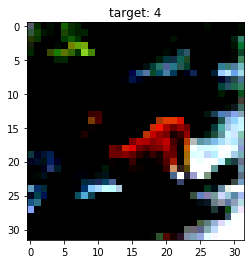

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

# print example
for k,(data, target) in enumerate(train_loader_mnist):
#for k,(data, target) in enumerate(val_loader_mnist):
    ind = 37
    data = data#['x']
    target = target#['y']
    print('data', data.shape, data.device ,data.dtype, data.min(), data.max())
    print('target', target.shape, target.device, target.dtype, target.min(), target.max())
    img = data[ind].permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f'target: {target[ind]}')
    break
    
print(len(train_loader_mnist))
print(len(val_loader_mnist))

# model parameters

In [5]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from flamingChoripan.myUtils.lists import get_list_of_dicts, merge_lists, Iter, decompose_dict_Iter
from baseline_models import MLPClassifier, CNN2DClassifier

mdl_params = {
    #'mdl_class':MLPClassifier,
    'mdl_class':CNN2DClassifier,
    'mdl_kwargs':{
        'dropout':0.5,
        #'dropout':0.0,
        'cnn_features':[16, 32, 64],
        #'cnn_features':[16, 32],
        'uses_mlp_classifier':True,
        #'uses_mlp_classifier':False,
    },
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# training

In [ ]:
%load_ext autoreload
%autoreload 2
from flamingChoripan.myUtils.prints import print_bar
import torch.optim as optims
from flamingChoripan.tinyFlame import C_
from flamingChoripan.tinyFlame.handler import ModelsTrainHandler
from flamingChoripan.tinyFlame.train_handlers import NewTrainHandler
from flamingChoripan.tinyFlame.losses import NewLossCrit, crossentropy
from flamingChoripan.tinyFlame.optimizers import NewOptimizer
from flamingChoripan.tinyFlame.metrics import NewMetricCrit, onehot_accuracy, dummy_accuracy

LOAD = 0

#### LOSS
loss_kwargs = {
    'model_output_is_with_softmax':False,
    'target_is_onehot':False,
    'target_is_onehot':False,
    #'pred_dict_key':'x',
    #'target_dict_key':'y',
}
loss_crit1 = NewLossCrit(crossentropy, loss_kwargs)
loss_crit2 = NewLossCrit(crossentropy, loss_kwargs)

#### METRICS
metric_crits = [
    NewMetricCrit('accuracy', onehot_accuracy, loss_kwargs),
    NewMetricCrit('dummy-accuracy', dummy_accuracy, loss_kwargs),
]

#### OPTIMIZERS
optimizer_kwargs = {
    'opt_kwargs':{
        'lr':1e-3,
    },
    'decay_kwargs':{
        'lr':0.9,
    }
}
optimizer1 = NewOptimizer(optims.Adam, **optimizer_kwargs)
optimizer2 = NewOptimizer(optims.Adam, **optimizer_kwargs)

trainh_config = {
    'early_stop_epochcheck_epochs':1, # every n epochs check
    #'early_stop_epochcheck_epochs':2, # every n epochs check
    'early_stop_patience_epochchecks':int(1e2),
    #'save_mode':C_.SM_NO_SAVE,
    #'save_mode':C_.SM_ALL,
    #'save_mode':C_.SM_ONLY_ALL,
    #'save_mode':C_.SM_ONLY_INF_METRIC,
    #'save_mode':C_.SM_ONLY_INF_LOSS,
    'save_mode':C_.SM_ONLY_SUP_METRIC,
}
model1 = mdl_params['mdl_class'](**mdl_params['mdl_kwargs'])
#assert 0
#model2 = SimpleClassifier()
train_handlers = [
    NewTrainHandler('crossentropy', model1, optimizer1, loss_crit1, metric_crits, **trainh_config),
    #NewTrainHandler('lower-bound', model2, optimizer2, loss_crit2, metric_crits, **trainh_config),
]
#train_handlers = NewTrainHandler('crossentropy', model, optimizer1, loss_crit, metric_crits, **train_config)

mtrain_config = {
    'id':0,
    'epochs_max':int(1e3),
    'save_dir':'save',
}
model_name = model1.get_name()
train_handler = ModelsTrainHandler(model_name, train_handlers, **mtrain_config)
train_handler.build(gpu_index=0)
train_handler.fit_loader(train_loader_mnist, val_loader_mnist, load=LOAD) # FIT

In [ ]:
%load_ext autoreload
%autoreload 2
import flamingChoripan.tinyFlame.plots as tfplots

### training plots
fig, ax = tfplots.plot_trainloss(train_handler)
fig, ax = tfplots.plot_evaluation_loss(train_handler)
fig, ax = tfplots.plot_evaluation_metrics(train_handler)
#fig, ax = tfplots.plot_optimizer(train_handler, save_dir=mtrain_config['images_save_dir'])
plt.show()
        

# prediction and CM